# Introduction

## Overview

This is a variation of [the original Analysis notebook](https://github.com/kamfonas/squadBERT/blob/main/notebooks/Analysis_v1.ipynb) with added functionality to exploit json files produced after validation or testing. 

Our premise, as described in more detail in the Analysis notebook, is that in addition to using exact match or F1 scores, measuring the proximity to the top prediction of the correct answer, provides useful insight into the progress of learning, hyperparameter tuning, or the comparison of models and architectures. 

We initially adopt the formatting proposed by Huggingface since their hub includes a large collection of architectures and models for the QA task. At the end of validation or test runs, a post-processing function yields a json file with the N-best answers for each example. Using N=20, for example, we can  extract the top 20 predictions for each example tested. Since we know the top 4 answers for every example from the golden dataset, we can try to match them in the top 20-list, and rank or score the proximity of the correct answers to highest confidence predictdion. 

This notebook demonstrates how we can pair the golden answers to our top-N predictions and calculates various metrics that measure proximity or rank of the correct answer.

## Postprocessing and Metrics 
We follow the postprocessing of the question-answering model output from logits to the computation of exact match (EM) and F1 metrics. 
These metrics deal with the top prediction. When this prediction is incorrect, it is common that a golden answer matches some other one of the top-N predictions. We look for a statistic that quantifies the proximity of the golden aswer in the top-N prediction pecking order of the evaluation set. We use the discounted rank of the prediction that matches the golden answer, so that the further down the order of predictions the lower the contribution of a correct match.  

## From Logits to Predictions
We assume that our evaluation set contains $M$ question-answer examples with varying context length $N^{(i)}$ measured in word tokens. For each example $i \in [1,M]$ the output layer of the model returns a start and an end prediction vector of logit values $\hat{y}^{S(i)}_j$  and $\hat{y}^{E(i)}_j$ where $j \in [1,N^{(i)}]$. These two logit vectors are treated as estimations of the *log of the odds* that the token in position $j$ marks the start or end token position of the answer segment respectively. By passing these logit vectors through a softmax function, the log of the odds is converted to prediction probability distribution vectors, $\hat{p}_j^{S(i)}$ and $\hat{p}_j^{E(i)}$ of the same shape as the logits.  

 In a perfect world, we should be able to use the highest probability start and end indexes to identify the highest probability answer prediction. 
    $$S^{(i)}=\underset{j\in [1,N]}{\arg\max}\,(\hat{p}_j^{S(i)})$$
    $$E^{(i)}=\underset{j\in[1,N]}{\arg\max}\,(\hat{p}_j^{E(i)})$$
The best answer prediction is the span of the context that starts at position $S^{(i)}$ and ends at $E^{(i)}$.   
 In the real world these answer spans may be invalid. For example, the end-position may precede the start-position or the  span length may exceed the allowed threshold or either of the positions may be out of bounds. These situations can be checked and controlled by constraints or other strategies that are implementation dependent. Such a strategy is to avoid the out-of-bounds constraint by properly masking the token sequence before applying the softmax. 
 
 Since some spans may be invalid, we need a strategy to choose the next best prediction span if the top choice is invalid. Should we try the next best end or maybe the next start or skip to the next pair? Or should we consider the question unanswerable? Instead of dealing with two independent probability distributions for the starts and ends it would be better to have a function that generates an ordered list of answers and their corresponding probabilities. This list could theoretically include all possible spans, but in practice a handful of them would be enough. In our tests, we use the  Huggingface framework which uses such a method.

Visualize a weight matrix of all possible combinations of start (rows) and end (columns): $\bf{\hat{w}}^{(i)} \in \mathcal{R}^{N^{(i)} \times N^{(i)}}$. Each cell of the matrix represents a possible span, and the value denotes the rank from most probable to least probable answer prediction. Cells denoting invalid spans should have zero-weight. For example, all elements below the diagonal that denote ends before starts should be zero, or outside the band where the answer span length exceeds a given threshold would also be set to zero. The rest of the valid cells will be assigned a computed probability (or weight) that reflects our chosen prioritization scheme. We need a function that checks span validity and combines start and end probabilities to produce a single value for each candidate span. The following are some of these choices:

### Product:
   The favored combinations are those which have both start and end probabilities high. A near-zero end probability penalizes the combination:
   $$w^{SE}=p^S p^E$$

### Harmonic Mean:
   This is a variation of the product method:
   $$w^{SE}=\frac{2 p^S p^E}{p^S + p^E}$$

### Average:
   The average probability of start and end is what we used in our evaluation. 
   $$w^{SE}=\frac{p^S + p^E}{2}$$

### Weighted Average:
   The idea here is to place more emphasis on the probability of the starting token than the ending token. 
   $$w^{SE}=\frac{w^S p^S + w^E p^E}{w^S+w^E}$$

   Weighing the start twice as much as the end is proposed [here](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf)

The cells of the matrix can be ordered with the top choice being the prediction. We use the top-N choices out of this matrix to support a statistic that measures the proximity of the golden answer to the top prediction.  

In practice, it is more efficient to reduce the matrix to the top-ranking starts and ends and avoid the cost of building the whole matrix. It would be interesting to study how each of these methods affect the prediction and the impact on performance. We have not been able to identify such a study although researchers do consider and try such alternatives in optimizing their models. 


In [1]:
#https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5
#import pickle5 as pickle
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib
#import wget
from utils_anal import *
#rename things that arent logs later
import os
from pathlib import Path
import json
from collections import Counter
import datetime
import datasets
from datasets import ClassLabel, Sequence, load_dataset, load_metric
import random
import pandas as pd
from IPython.display import display, HTML
import datetime
import string
import re
from statistics import  median_grouped
from tqdm import tqdm


In [2]:
def download_url(url, output_path, show_progress=True):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    if show_progress:
        # Download with a progress bar
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)
    else:
        # Simple download with no progress bar
        urllib.request.urlretrieve(url, output_path)

stanford_squad2_dev_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"
save_stanford_squad2 = "stanford_squad2_dev.json"
download_url(stanford_squad2_dev_url,save_stanford_squad2)

dev-v2.0.json: 4.37MB [00:00, 8.63MB/s]                                         



## Load the SQuAD Dataset

We now download the squad_v2 dataset from the hub. We will use it to get the golden answers so that we can calculate performance metrics. The dataset class has a method for loading the dataset from the huggingface hub or from a disk location. The loaded object belongs to that class



In [3]:
dataset_name = "squad_v2"
#dataset_name = "squad"

raw_datasets = load_dataset(dataset_name)
print('The raw dataset dictionary contains two datasets of type %s:' % (type(raw_datasets["validation"])))
raw_datasets

#['num_rows']


Found cached dataset squad_v2 (/Users/gabrielalon/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

The raw dataset dictionary contains two datasets of type <class 'datasets.arrow_dataset.Dataset'>:


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

The following function allows us to inspect the contents of the downloaded data. Every time the function is invoked it prduces a new set of random selections.

Every time you execute this function it will generate new samples. Use it to find IDs you want to use for testing.

In [4]:
show_random_elements(raw_datasets["validation"])

,id,title,context,question,answers
0,5710ed7bb654c5140001fa2b,Huguenot,"Some Huguenots fought in the Low Countries alongside the Dutch against Spain during the first years of the Dutch Revolt (1568–1609). The Dutch Republic rapidly became a destination for Huguenot exiles. Early ties were already visible in the ""Apologie"" of William the Silent, condemning the Spanish Inquisition, which was written by his court minister, the Huguenot Pierre L'Oyseleur, lord of Villiers. Louise de Coligny, daughter of the murdered Huguenot leader Gaspard de Coligny, married William the Silent, leader of the Dutch (Calvinist) revolt against Spanish (Catholic) rule. As both spoke French in daily life, their court church in the Prinsenhof in Delft held services in French. The practice has continued to the present day. The Prinsenhof is one of the 14 active Walloon churches of the Dutch Reformed Church. The ties between Huguenots and the Dutch Republic's military and political leadership, the House of Orange-Nassau, which existed since the early days of the Dutch Revolt, helped support the many early settlements of Huguenots in the Dutch Republic's colonies. They settled at the Cape of Good Hope in South Africa and New Netherland in North America.",When was the Dutch Revolt?,"{'text': ['1568–1609', '1568–1609', '1568–1609'], 'answer_start': [121, 121, 121]}"
1,5729d878af94a219006aa66b,Economic_inequality,"In a purely capitalist mode of production (i.e. where professional and labor organizations cannot limit the number of workers) the workers wages will not be controlled by these organizations, or by the employer, but rather by the market. Wages work in the same way as prices for any other good. Thus, wages can be considered as a function of market price of skill. And therefore, inequality is driven by this price. Under the law of supply and demand, the price of skill is determined by a race between the demand for the skilled worker and the supply of the skilled worker. ""On the other hand, markets can also concentrate wealth, pass environmental costs on to society, and abuse workers and consumers."" ""Markets, by themselves, even when they are stable, often lead to high levels of inequality, outcomes that are widely viewed as unfair."" Employers who offer a below market wage will find that their business is chronically understaffed. Their competitors will take advantage of the situation by offering a higher wage the best of their labor. For a businessman who has the profit motive as the prime interest, it is a losing proposition to offer below or above market wages to workers.",What controls wages in a purely capitalist mode of production?,"{'text': ['the market', 'market', 'market'], 'answer_start': [226, 230, 230]}"
2,5725edfe38643c19005acea3,"Fresno,_California","The ""West Side"" of Fresno, also often called ""Southwest Fresno"", is one of the oldest neighborhoods in the city. The neighborhood lies southwest of the 99 freeway (which divides it from Downtown Fresno), west of the 41 freeway and south of Nielsen Ave (or the newly constructed 180 Freeway), and extends to the city limits to the west and south. The neighborhood is traditionally considered to be the center of Fresno's African-American community. It is culturally diverse and also includes significant Mexican-American and Asian-American (principally Hmong or Laotian) populations.",Which neighborhood lies west of the 41 freeway?,"{'text': ['""West Side""', 'West Side', 'West Side'], 'answer_start': [4, 5, 5]}"


We are interested in the validation dataset. Here is its type:

In [5]:
type(raw_datasets["validation"])

datasets.arrow_dataset.Dataset

## Index by ID


In order to be able to match the entries of the original dataset with those of our prediction, we need to map each ID to the respective row number of the validation raw dataset. We construct an index, as a dictionary, keyed on the ID from the validataion raw dataset and pointing to the corresponding row-number of the validation dataset.

In [6]:
ix_id = dict([(x['id'],i) for i,x in enumerate(raw_datasets['validation'])])

Now, we can use this index to get to the golden answer for a given id. This mapping is repeated inside the class defined in the next section below. 



# The ResultSet Class

## Class Overview


To facilitate management and data collection we build a dictionary of available data sources derived from runs logged under a user-provided root directory (saveRoot.)

The SaveRoot descendent directories are searched for all instances of a fiile named *eval_nbest_predictions.json*. Every directory containing this file is a potential source for N-best predictions. We load the ones that satisfy these additional conditions:

1.  if a *config.json* file exists in the same directory
2.  If a file named *all_results.json* exists in the same directory

These files are written by the training/evaluation process after successful completion of a run. 

The function **get_resultsets_from_root(saveRoot)** performs the above steps and returns a directory with the following information:

<dl>
<dt><b>mtime</b></dt>
    <dd>The last modification time of the eval_nbest_predictions.json file</dd>
<dt><b>config</b></dt>
    <dd>Model configuration of used to produce the top-N results</dd>
<dt><b>all_results</b></dt>
    <dd>The results of the last run that produced the top-N results</dd>
<dt><b>topN</b></dt>
    <dd>A dictionary keyed on the ID of each question pointing to an ordered N-long list in descending order of probability with the predicted details. These details are organized as dictionaries containing:
    </ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b></li>
    </ul>
    </dd>
<dt><b>null odds</b></dt>
    <dd>The odds determining the likelihood that this is a no-answer question for each example</dd>
</dl>

We augment our **prediction** dictionary to include the **id** as a field, the **rank** of each predicted answer (with values from 0 to N), and the gold answers (**goldenAnswers**), which is a list containing the distinct text of the answers found in the SQuAD_V2 dataset. Finally, we also include an indicator showing whether the prediction is the **correct** answer.

The **contextLen** field denotes the original number of characters in the context field. This can be used for normalization when comparing probabilities of different size contexts. A more appropriate length would be the number of tokens or number of words in the context.  

Notice that to indicate no answer, the prediction text is an empty string while the goden answer is an empty list. 

The class, when initialized with a root directory, searches all its subdirectories to find top-N prediction output files. It also accepts an original examples dataset which was used as input to our training/evaluation script. From these two pieces of information, the class materializes a number of dictionaries and carries methods for data extraction and generating all necessary values for visualizations. 

Method topNPredsDF takes an optional maxBins parameter that sets a limit to the rank values. The function returns a pandas dataframe that contains the following columns:
    <ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b> derived from the combination of start and end probabilities</li>
    <li><b>experiment</b> derived from the output directory path</li>
    <li><b>example id</b></li>
    <li><b>rank</b> in descending order of probability for as many available ranks are available in the logs.
    <li><b>bins</b> this is driven by the topK parameter and is assigned the rank value up to the maxBins parameter. This is a convenient way to throttle very long top-N lists to a desired max size for plotting purposes. All the rows that exceed the rank are still available, but the rank number is the same maximum value (defaults to 20)</li>
    <li><b>correct</b> is True if it matches one of the golden answers using the exact match logic (EM) regardless of rank</li>
    <li><b>contextLen</b> in characters</li>
    </ul>



## Create a Class Instance and List Summary Info 

In [7]:
RS = ResultSet("../save-models/squad_v2",raw_datasets["validation"])


In [8]:
RS.summaryDF()


,experiment,mtime,example_count,topK
0,/bert-base-uncased/001,2021-08-18T11:46:50,11873,10
1,/bert-base-uncased/007,2021-08-19T04:49:12,11873,10
2,/bert-base-uncased/009,2021-08-26T11:57:46,11873,100
3,/bert-base-uncased/010,2021-09-11T12:28:40,11873,10
4,/bert-large-cased-whole-word-masking/003,2021-08-24T22:11:12,11873,10
5,/deepset/bert-large-uncased-whole-word-masking...,2021-09-03T19:03:22,11873,10
6,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-08-22T17:27:10,11873,10
7,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-09-03T18:45:30,11873,10
8,/navteca/electra-base-squad2/005,2021-08-17T13:50:16,11873,10
9,/navteca/electra-base-squad2/006,2021-08-20T16:27:10,11873,10


In [10]:
RS.experiments

['/bert-base-uncased/001',
 '/bert-base-uncased/007',
 '/bert-base-uncased/009',
 '/bert-base-uncased/010',
 '/bert-large-cased-whole-word-masking/003',
 '/deepset/bert-large-uncased-whole-word-masking-squad2/001',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/009',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/011',
 '/navteca/electra-base-squad2/005',
 '/navteca/electra-base-squad2/006',
 '/navteca/electra-base-squad2/007',
 '/navteca/roberta-base-squad2/001',
 '/navteca/roberta-base-squad2/002',
 '/twmkn9/distilbert-base-uncased-squad2/003',
 '/twmkn9/distilbert-base-uncased-squad2/004',
 '/twmkn9/distilbert-base-uncased-squad2/008']

The summary lists the name (derived from the directory structure) for each experiment captured in the class, followed by the last modification date, , the number of examples in the dataset, and the length of the top-K predictions recorded in the logs.


## Assign Labels to Experiments
We assign abbreviated labels for each experiment to keep legends small

In [11]:
short_labels = []
for exp in RS.experiments:
    nm1 = exp.split('/')
    nm0 = nm1[-2]
    #print(exp,str(namSplit2[0])+'/'+str(namSplit1[-1]))
    nm0 = re.sub('-base','',nm0)
    nm0 = re.sub('large','lg',nm0)
    nm0 = re.sub('uncased','uc',nm0)
    nm0 = re.sub('cased','cas',nm0)
    nm0 = re.sub('whole-word-masking','wwm',nm0)
    nm0 = re.sub('-finetuned','',nm0)
    nm0 = re.sub('-squad.*2','-sq2',nm0)
    nm0 = re.sub('-[0-9]{4}','',nm0)  
    short_labels.append(str(nm0+'/'+str(nm1[-1])))
RS.set_labels(short_labels)
RS.labels

['bert-uc/001',
 'bert-uc/007',
 'bert-uc/009',
 'bert-uc/010',
 'bert-lg-cas-wwm/003',
 'bert-lg-uc-wwm-sq2/001',
 'longformer-sq2/009',
 'longformer-sq2/011',
 'electra-sq2/005',
 'electra-sq2/006',
 'electra-sq2/007',
 'roberta-sq2/001',
 'roberta-sq2/002',
 'distilbert-uc-sq2/003',
 'distilbert-uc-sq2/004',
 'distilbert-uc-sq2/008']

In [12]:
abbrevLabel = {RS.experiments[i] : RS.labels[i] for i in range(len(RS.labels))}

## Looking-up Information for a Specific Example ID

In [13]:
RS.dataset[RS.ix_id['571c96095efbb31900334dc0']] 

{'id': '571c96095efbb31900334dc0',
 'title': 'Oxygen',
 'context': 'Oxygen is more soluble in water than nitrogen is. Water in equilibrium with air contains approximately 1 molecule of dissolved O\n2 for every 2 molecules of N\n2, compared to an atmospheric ratio of approximately 1:4. The solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·L−1) dissolves at 0 °C than at 20 °C (7.6 mg·L−1). At 25 °C and 1 standard atmosphere (101.3 kPa) of air, freshwater contains about 6.04 milliliters (mL) of oxygen per liter, whereas seawater contains about 4.95 mL per liter. At 5 °C the solubility increases to 9.0 mL (50% more than at 25 °C) per liter for water and 7.2 mL (45% more) per liter for sea water.',
 'question': 'How much more oxygen dissolves at 0 degrees C than at 20 degrees C?',
 'answers': {'text': ['twice',
   '50% more',
   'about twice as much',
   'twice as much',
   'twice'],
  'answer_start': [286, 579, 280, 286, 286]}}

In [14]:
RS.topNPreds()[0]['5728fc9e1d04691400778f15'][0:1]

[{'start_logit': 6.09079647064209,
  'end_logit': 5.010820388793945,
  'text': '',
  'probability': 0.999997615814209,
  'experiment': '/bert-base-uncased/001',
  'id': '5728fc9e1d04691400778f15',
  'rank': 0,
  'goldAns': ["the leaflets will have to be given to the leafleter's own jury as evidence",
   "if they arrest fully informed jury leafleters, the leaflets will have to be given to the leafleter's own jury as evidence"],
  'correct': False,
  'contextLen': 1453,
  'bin': 0}]

In [15]:
ids=['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']
RS.dataset[RS.ix_id[ids[0]]] 

{'id': '57263c78ec44d21400f3dc7c',
 'title': 'Packet_switching',
 'context': 'ARPANET and SITA HLN became operational in 1969. Before the introduction of X.25 in 1973, about twenty different network technologies had been developed. Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core. In the datagram system, the hosts have the responsibility to ensure orderly delivery of packets. The User Datagram Protocol (UDP) is an example of a datagram protocol. In the virtual call system, the network guarantees sequenced delivery of data to the host. This results in a simpler host interface with less functionality than in the datagram model. The X.25 protocol suite uses this network type.',
 'question': '2 differences betwen X.25 and ARPNET CITA technologies ',
 'answers': {'text': ['Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the netwo

## Explore random example top-K predictions
But first, let's explore the data dictionary we assembled and look at a three random examples. 

1.  We first select **num_examples** (default to 3) numbers in the range of all the keys of the data dictionary
2.  Look up the keys that appear at these three sequencial positions in the sequence of all keys
3.  Get the values pointed to by those keys
4.  Build a data frame by traversing the list of each of the chosen values and extracting the field names and fields.
5.  Finally display the rank, predicted answer text,  golden answer list,  probability used to rank this choice, and whether this is a correct prediction. 

Every time the command is issued new random samples are displayed. 

In [16]:
DF = RS.show_random_qa_predictions(3,num_examples = 2, verbose = False)
DF


,id,rank,text,goldAns,probability,correct
0,5ad4f1c95b96ef001a10a727,0,"420,000",[],0.969650,False
1,5ad4f1c95b96ef001a10a727,1,"only 420,000",[],0.019168,False
2,5ad4f1c95b96ef001a10a727,2,"420,000.",[],0.004337,False
3,5ad4f1c95b96ef001a10a727,3,"1945 – only 420,000",[],0.003500,False
4,5ad4f1c95b96ef001a10a727,4,420,[],0.001124,False
5,5ad4f1c95b96ef001a10a727,5,"in 1945 – only 420,000",[],0.000925,False
6,5ad4f1c95b96ef001a10a727,6,000,[],0.000919,False
7,5ad4f1c95b96ef001a10a727,7,"420,",[],0.000148,False
8,5ad4f1c95b96ef001a10a727,8,"– only 420,000",[],0.000116,False
9,5ad4f1c95b96ef001a10a727,9,"only 420,000.",[],0.000086,False


We can save a latex version of the output

# EM and F1 Evaluation Metircs

These are extracted from the reported validation metrics for each experiment. They include exact match (EM) and F1 scores for the questions with answers and those with no answers separately, as well as all of them in total. Notice that there is no distinction between exact match and F1 for no-answer questions. 

In [17]:
RS.eval_metrics()

,EM_ans,F1_ans,F1-EM_ans_delta,noans,EM,F1,F1-EM_delta
0,70.951417,78.934411,7.982994,71.572750,71.262528,75.248310,3.985782
1,69.129555,76.915674,7.786119,77.022708,73.081782,76.969268,3.887485
2,68.522267,75.441761,6.919494,77.527334,73.031247,76.486041,3.454793
3,67.594467,74.788812,7.194345,77.443230,72.525899,76.117921,3.592022
4,76.180837,82.230080,6.049243,85.264929,80.729386,83.749677,3.020291
5,79.487179,85.444250,5.957071,82.321278,80.906258,83.880528,2.974271
6,75.033738,82.738118,7.704380,82.910008,78.977512,82.824186,3.846674
7,78.677463,85.534793,6.857330,81.126997,79.903984,83.327740,3.423756
8,77.918354,85.303190,7.384836,77.022708,77.469890,81.157021,3.687131
9,77.378543,85.117483,7.738940,81.328848,79.356523,83.220453,3.863930


## F1 is highly correlated with Exact Match
The following plot uses the data above to demonstrate the high correlation between EM and F1 scores.

Text(0, 0.5, 'EM')

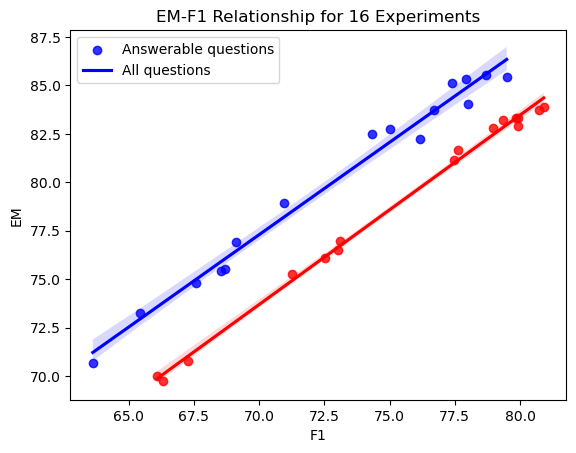

In [20]:
import seaborn as sns

X = RS.eval_metrics()
import warnings
warnings.filterwarnings('ignore')
#create scatterplot with regression line
sns.regplot(x='EM_ans',y='F1_ans',color='blue',data=X)
sns.regplot(x='EM',y='F1',color='red',data=X)

#plt.scatter(X.EM_ans,X.F1_ans,color='blue')
#plt.scatter(X.noans,X.noans,color='green')
#plt.scatter(X.EM,X.F1,color='red')

plt.title("EM-F1 Relationship for %i Experiments" % len(X))
plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1')
plt.ylabel('EM')


# Golden Prediction Rank

## Definition

The Golden Prediction Rank, or simply Golden Rank (GR)  is defined as the rank of the highest probability prediction that exactly matches one of the answers. Operationally, this is better visualized following these steps:

1.  Assume an ordered list from highest to lowest probability of all valid spans of the context of a given example
2.  Starting from the top, in descending probability order, try each of the spans and identify the first one that contains an exact match to any of the golden answers
3.  The rank of that element is the golden prediction rank (GR) for that example


## Top-10 GRs Fine-Tuned Model Eval Runs

These include all evaluations using models that we did not fine-tune or train, but downloaded them already fine-tuned on SQuAD v2.

We first extract the top-K ranking predictions for each experiment. 

In [21]:
grls_np, nas_np, maxBins, medians, grls = RS.calc_golden_ranks(maxBins = 10,experimentIdx=None)

We can now plot the topN golden predictions by rank. We superimpose the medians of ranks > 0.

In [22]:
L = [i for i in range(len(RS.labels)) if 'eval' in RS.labels[i]]
L_eval = [5,7,10,12,15]
L = L_eval

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rankEval.png'

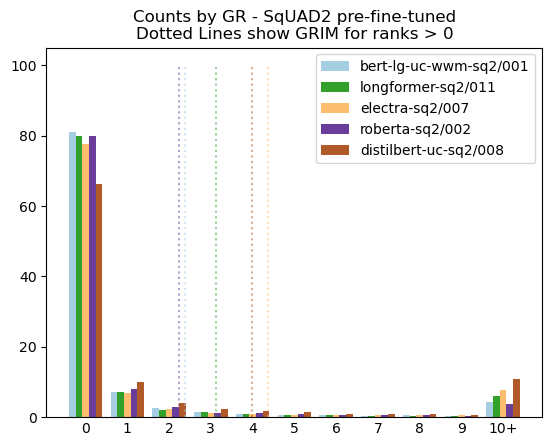

In [23]:
#from utils_anal import plot_golden_EM_by_rank
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rankEval.png' ,
                subject = 'SqUAD2 pre-fine-tuned')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

FileNotFoundError: [Errno 2] No such file or directory: '../assets/cumEM_rankEval.png'

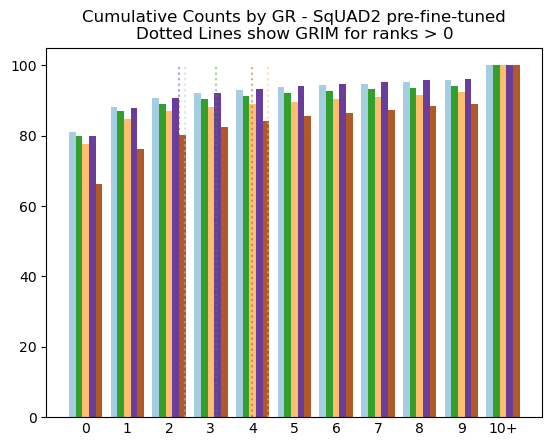

In [24]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rankEval.png'  ,
                subject = 'SqUAD2 pre-fine-tuned')


## Top-10 GRs Same Models with Our Added Fine-Tuning

These are the same models that have been fine-tuned by their authors, but we extended the fine-tuning with an additional up to 8 epochs

In [ ]:
L = [i for i in range(len(RS.labels)) if i not in L_eval and i > 3]

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rank10_ft_trVal.png'

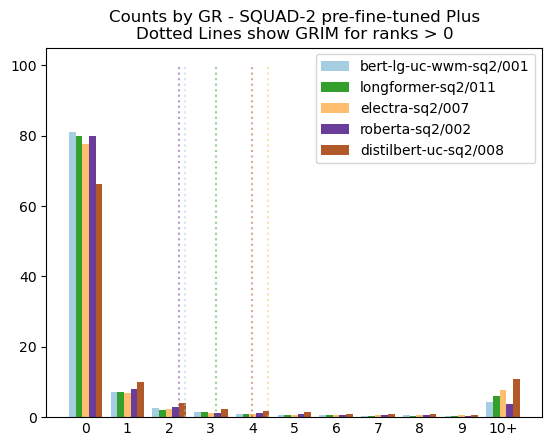

In [25]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_ft_trVal.png'  ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

FileNotFoundError: [Errno 2] No such file or directory: '../assets/cumEM_rank10_ft_trVal.png'

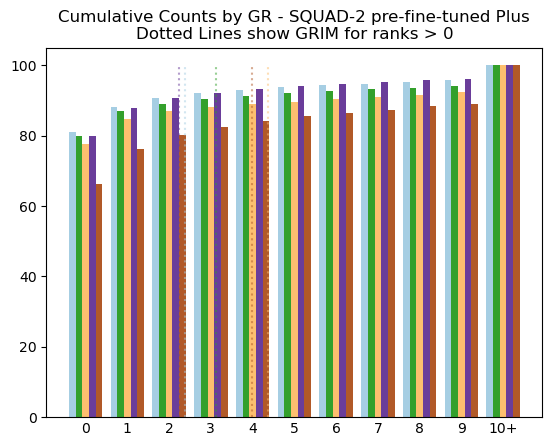

In [26]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_ft_trVal.png'   ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')


## Top-10 GRs BERT

These are BERT models that were pre-trained but not fine-tuned. We fine-tune them with 8 epochs of training. The only exception is the large BERT with the suffix "eval" which is fine-tuned and used without any training. Notice that this is not the same as the cased large we used and which we trained. 

In [27]:
#L = [i for i in range(len(RS.labels)) if 'bert-large' in RS.labels[i] or (i>11 and '/na/' not in RS.labels[i]) ]
#L = [i for i in range(len(RS.labels)) if  (i>11 and '/na/' not in RS.labels[i]) and 'large' not in RS.labels[i] ]
L = [0,1,2,3]

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rank10_bert.png'

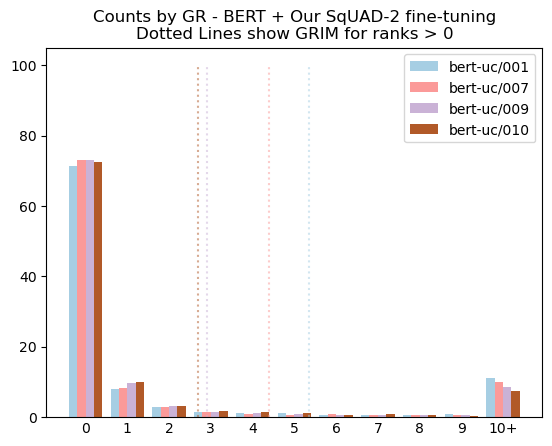

In [28]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bert.png'  ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

In [ ]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bert.png' ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )


## Top-10 GRs Electra & Roberta

In [ ]:
L = [i for i in range(len(RS.labels)) if 'electra' in RS.labels[i] or 'roberta' in RS.labels[i]]

In [ ]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

FileNotFoundError: [Errno 2] No such file or directory: '../assets/cumEM_rank10_electra.png'

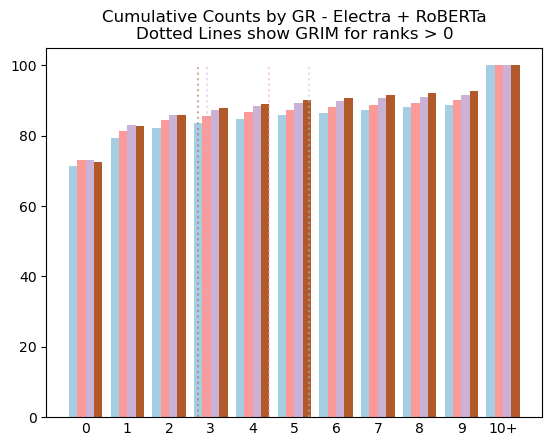

In [29]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa'  )


## Top-10 GRs Fine-Tuned DistilBERT & Longformer

In [ ]:
L = [i for i in range(len(RS.labels)) if 'distil' in RS.labels[i] or 'former' in RS.labels[i]]

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rank10_long_dist.png'

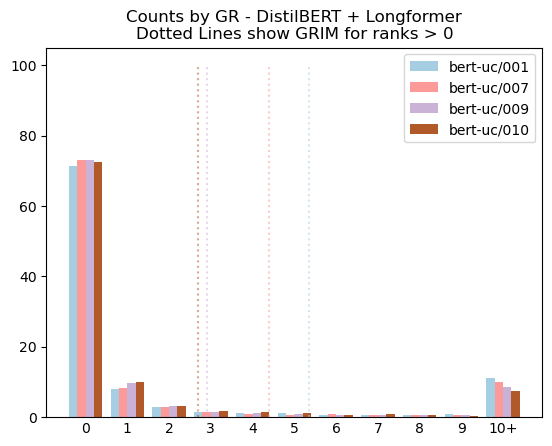

In [30]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_long_dist.png' ,
                subject = 'DistilBERT + Longformer'  )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

In [ ]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_long_dist.png'  ,
                subject = 'DistilBERT + Longformer')


## Top-10 GRs BERT Large (Cased vs. Uncased)

In [31]:
L = [i for i in range(len(RS.labels)) if 'bert-l' in RS.labels[i]]

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rank10_bertLarge.png'

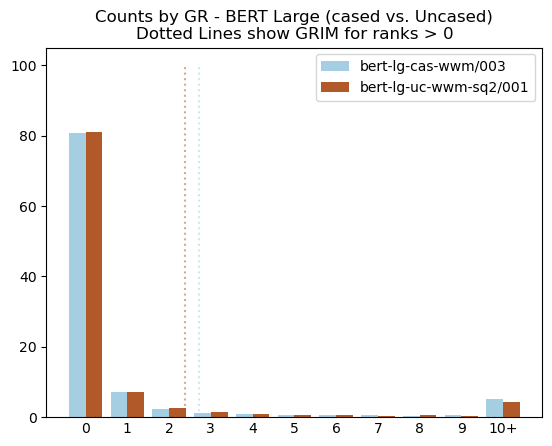

In [32]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bertLarge.png'  ,
                subject = 'BERT Large (cased vs. Uncased)')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

In [ ]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bertLarge.png' ,
                subject = 'BERT Large (cased vs. Uncased)' )


## Top-100 Golden Prediction Ranks > 0 (One Experiment)

In [33]:
grls_np_100, _ , _ ,_, _ = RS.calc_golden_ranks(
    maxBins = 100,experimentIdx=2)

FileNotFoundError: [Errno 2] No such file or directory: '../assets/EM_rank100.png'

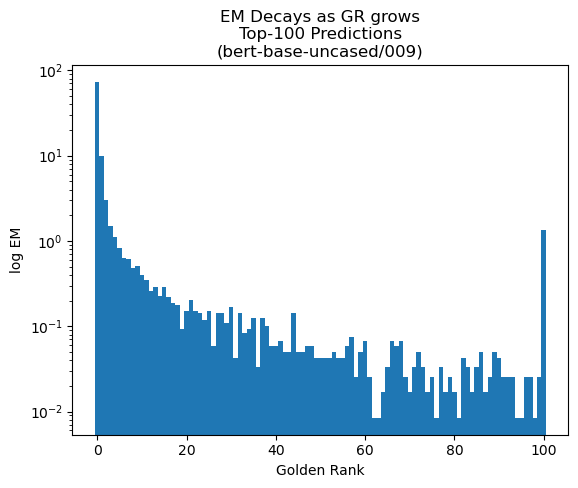

In [34]:
#Hs,Ms = plot_golden_EM_by_rank(grls_np_100, medians=[], cumulative = False,
#        skipRank0=False,labels=RS.labels,savePath='../assets/EM_rank100.png' )
lowx =0 #if skipRank0 else 0
title = 'EM Decays as GR grows\nTop-100 Predictions\n(bert-base-uncased/009)' 
#title = '%s%s' % (title,'\n(Ranks > 0 only)' if skipRank0 else '')
m = grls_np_100.shape[1]
maxBins = np.max(grls_np_100)
bins = [x for x in range(maxBins+2)]
A = plt.hist(grls_np_100.T,bins=maxBins+1,
        weights=np.ones(grls_np_100.T.shape)*100/m, 
        cumulative=False,align='left',histtype='bar',
        range=(lowx,(maxBins+1)))
plt.title(title)
plt.yscale("log")
plt.ylabel("log EM")
plt.xlabel("Golden Rank")
plt.savefig('../assets/EM_rank100.png',dpi=300,alpha=0.6)
plt.show()


# The Metrics


In [ ]:
colors = cm.Paired(np.linspace(0, 1, 6))
cmap=sns.color_palette("tab10")
print(cmap)
colors = [cmap[i] for i in [0,0,0,1,2,2,2,3,3,4,4,5,5,5,1]]

metrics = RS.eval_metrics()
metrics['GRIM'] = medians
metrics['label'] = RS.labels
metrics['Model'] = [lbl.split('-')[0] for lbl in RS.labels]
metrics['Model'] = ['bert-lg' if 'bert-lg' in lbl else mod for mod,lbl in zip(metrics['Model'],RS.labels)]


metrics

In [ ]:
fig, ax = plt.subplots()
sns.lmplot(x='F1-EM_delta',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1-EM_delta',y='GRIM',data=metrics,scatter=False)#, hue='Model')
#ax.set(xlabel="x-axis", ylabel="y-axis")plt.ylim(6.0, 0)
plt.title("GRIM to F1-EM-Delta Relationship")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1-EM Delta')
plt.ylabel('GRIM')
plt.savefig('../assets/F1-EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')
plt.show()

In [35]:
sns.lmplot(x='F1',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("F1-GRIM Relationship")
plt.xlabel('F1')
plt.ylabel('GRIM')
plt.savefig('../assets/F1_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

NameError: name 'metrics' is not defined

In [36]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

NameError: name 'metrics' is not defined

In [37]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
#ax2 = ax.twinx()
#sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_scatter.png',dpi=300,bbox_inches='tight')

NameError: name 'metrics' is not defined

# Clustering of Examples by Model Performance

In [38]:
grs = grls_np # GR by example X experiment
grs_na = grls_np[:,list(nas_np[0,:])]
grs_ans = grls_np[:,list(nas_np[0,:]==0)]
grs_means = [np.mean(x) for x in grs.T]
grs_na_means = [np.mean(x) for x in grs_na.T]
grs_ans_means = [np.mean(x) for x in grs_ans.T]
grs_std = [np.std(x) for x in grs.T]
grs_na_std = [np.std(x) for x in grs_na.T]
grs_ans_std = [np.std(x) for x in grs_ans.T]
grs_pr = grls_np[:,list(np.min(grls_np,axis=0) == 0)]

#grs_pr_na = grls_np[:,list(np.min(grls_np,axis=0) == 0 and nas_np[0,:])]

grs_sec = grls_np[:,list(np.min(grls_np,axis=0) > 0)]
grs_pr_means = [np.mean(x) for x in grs_pr.T]
grs_pr_std = [np.std(x) for x in grs_pr.T]
grs_sec_means = [np.mean(x) for x in grs_sec.T]
grs_sec_std = [np.std(x) for x in grs_sec.T]


In [39]:
print("na",len(grs_na_means))
print("ans",len(grs_ans_means))
print("all",grs.shape)



na 5945
ans 5928
all (16, 11873)


In [40]:
X = np.max(grls_np,axis=0)
XX = np.sum(grls_np<10,axis=1)
X10 = np.sum(X<10)
XX10 = np.mean(XX)
print(XX10)
m = X.shape[0]
print(X.shape)
print('There are %i examples (%.2f) that are consistently under rank 10'%(X10,X10/m*100))
print('The average experiment has %i examples (%.2f)%% under rank 10'% (XX10,XX10/m*100))
print('The best experiment has %i examples (%.2f)%% under rank 10'% (np.max(XX),np.max(XX)/m*100))

10969.875
(11873,)
There are 8576 examples (72.23) that are consistently under rank 10
The average experiment has 10969 examples (92.39)% under rank 10
The best experiment has 11418 examples (96.17)% under rank 10


## GR Mean & std of All experiments by Example

We plot the 16 experiment golden rank mean vs. the standard deviation for each example. The first plot below distinguishes the examples into two categories: The gray points denote those examples predicted  correctly by at least one experiment. The blue points denote the rest of the examples that only appeared in secondary predictions.

FileNotFoundError: [Errno 2] No such file or directory: '../assets/GR_mean_vs_std_Predicted_by_at_least_one_model.png'

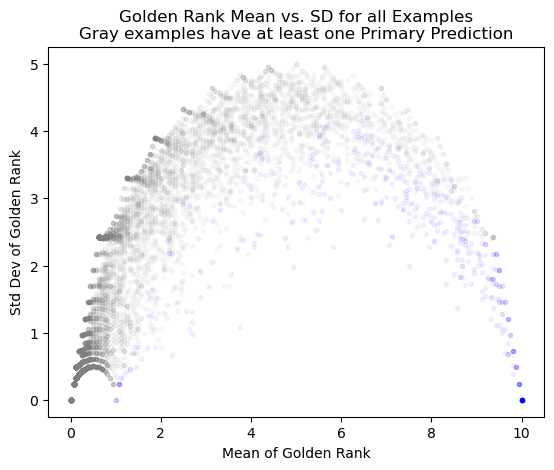

In [41]:
plt.scatter(grs_pr_means,grs_pr_std,alpha = 0.05, marker = '.',color = 'grey')
plt.scatter(grs_sec_means,grs_sec_std,alpha = 0.05, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Golden Rank Mean vs. SD for all Examples\nGray examples have at least one Primary Prediction")
plt.savefig('../assets/GR_mean_vs_std_Predicted_by_at_least_one_model.png',dpi=300)

The following statistics pertain to examples that have been predicted correctly at least once:

In [ ]:
m=grls_np.shape[1]
pr_na = np.sum([ a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr_ans = np.sum([ not a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr = np.sum(np.min(grls_np,axis=0) == 0)
print('Total number of examples:',m)
print ('There are %i examples that have been predicted correctly by at leat one experiment' % pr)
print('They are about evenly split between answerable (%i) and unanswearable (%i) examples'% (pr_ans,pr_na))
print ('The remaining %i examples (%.2f%%) are the only ones that appear exclusively in secondary predictions and none of the primary' %\
    (m-pr, (m-pr)/m*100))


The second graph shows the same mean-standard deviation plot for each example, in green for answerable examples and  red for those that have no answer.The answerable examples are more consistently predicted by the 16 models and remain closer to the higher ranking predictions (towards 0) while the no-answer examples are predicted less successfully and with wider variability.

In [ ]:
plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
plt.scatter(grs_ans_means,grs_ans_std,alpha = 0.05, marker = '.',color = 'green')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Example Golden Rank Mean vs. SD\nGreen examples have answers, Red are Unanswerable")
plt.savefig('../assets/GR_mean_vs_std_ans_vs_noAns.png',dpi=300)

The following experiment counts correspond to the three points with zero standard deviation. These denote examples that have been consistently ranked for all 15 experiments.

In [ ]:
m = len(grs_means)
print('Examples ranked 0 for all experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_means]),np.sum([x==0 for x in grs_means])/m*100))
print('Examples ranked 10 or higher for all experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_means]),np.sum([x==10 for x in grs_means])/m*100))
v01 = np.sum([x==0 for x in grs_std])-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
print('Examples ranked 1 for all experiments: %i or %.2f%%' % (v01,v01/m*100))
print('Examples ranked 0 for all experiments with no answer: %i or %.2f%%'%(np.sum([x==0 for x in grs_na_means]),np.sum([x==0 for x in grs_na_means])/m*100))
print('Examples ranked 10 or higher for all experiments with no answer: %i or %.2f%%'%(np.sum([x==10 for x in grs_na_means]),np.sum([x==10 for x in grs_na_means])/m*100))
v11 = np.sum([x==0 for x in grs_na_std])-np.sum([x==10 for x in grs_na_means])-np.sum([x==0 for x in grs_na_means])
print('Examples ranked 1 for all experiments with no answer: %i or %.2f%%'%(v11,v11/m*100))
print('Examples ranked 0 for all answerable experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_ans_means]),np.sum([x==0 for x in grs_ans_means])/m*100))
print('Examples ranked 10 or higher for all answerable experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_ans_means]),np.sum([x==10 for x in grs_ans_means])/m*100))
v21=np.sum([x==0 for x in grs_ans_std])-np.sum([x==10 for x in grs_ans_means])-np.sum([x==0 for x in grs_ans_means])
print('Examples ranked 1 for all answerable experiments: %i or %.2f%%'%(v21,v21/m*100))



#grs.shape

In [ ]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))


## Error Analysis - Clusters of Interest

### Four rank-1, sdv-0 examples
The next cell produces the four examples that rank 1 for all experiments. The result shows that three of them involve an incorrect "No Answer" prediction and one looks like an aberration in the golden answers where the returned rank-0 answer should be a correct answer. 

In [51]:
df = RS.topNPredsDF()#topK=5)#, experimentIdx =experimentID)
df['experiment'] = [abbrevLabel[exp] for exp in df['experiment']]
df['id_short'] = [i[20:] for i in df['id']]

In [98]:
pd.set_option('display.max_colwidth', 0)
[(x,y) for x,y in zip(grs_std,grs_means) if x ==0 and y == 1]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = np.where(np.prod(grs,axis=0)==1)[0].tolist()
print(ixs)
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in np.where(np.prod(grs,axis=0)==1)[0].tolist()]
print(ids)
df1 = df.loc[df.id.isin(ids)][['text','probability','id_short','rank','goldAns','correct','id']]
#with open('../assets/errors_GR1_example_predictions_4.tex','w') as F:
#    F.write(df1.query('rank < 2').to_latex(index=False))
display( df1.query('rank < 2'))



[4425, 5088, 5557, 5860]
['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']


,text,probability,id_short,rank,goldAns,correct,id
46383,,0.999946,dc7c,0,"[the division of functions and tasks between the hosts at the edge of the network and the network core., Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, division of functions and tasks between the hosts at the edge of the network and the network core]",False,57263c78ec44d21400f3dc7c
46384,Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core,0.000045,dc7c,1,"[the division of functions and tasks between the hosts at the edge of the network and the network core., Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, division of functions and tasks between the hosts at the edge of the network and the network core]",True,57263c78ec44d21400f3dc7c
53241,microscopic analysis of oriented thin sections of geologic samples,0.518779,c7da,0,"[microscopic analysis of oriented thin sections, microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples]",False,57267d52708984140094c7da
53242,microscopic analysis,0.481057,c7da,1,"[microscopic analysis of oriented thin sections, microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples]",True,57267d52708984140094c7da
58120,,1.000000,0080,0,[Brownlee],False,5728dc2d3acd2414000e0080
...,...,...,...,...,...,...,...
2948090,microscopic analysis of oriented thin sections,0.200961,c7da,1,"[microscopic analysis of oriented thin sections, microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples]",True,57267d52708984140094c7da
2952926,,0.996014,0080,0,[Brownlee],False,5728dc2d3acd2414000e0080
2952927,Brownlee,0.003980,0080,1,[Brownlee],True,5728dc2d3acd2414000e0080
2956002,,0.995019,8787,0,"[waste, a lot of waste]",False,572742bd5951b619008f8787


### Sample of highly polarized examples

In [55]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.8  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [exs[0] for exs in random.sample(ixs,5)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs]
print(ids)
for id in ids:
    print('Example ID:',id)
    print(RS.dataset[RS.ix_id[id]])
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    #df1['experiment'] = [abbrevLabel[exp] for exp in df1['experiment']]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    #with open('../assets/errors_GR_polar_by_experiment_id_%s.tex'%id,'w') as F:
   #     F.write(df2.to_latex(index=False))
    display( df2)#.query('rank < 5'))

['5705fec152bb89140068977b', '5a636ede68151a001a9222d6', '5a8221dc31013a001a335231', '5ad40397604f3c001a3ffd86', '5a8943753b2508001a72a571']
Example ID: 5705fec152bb89140068977b
{'id': '5705fec152bb89140068977b', 'title': 'Southern_California', 'context': 'Each year, the southern California area has about 10,000 earthquakes. Nearly all of them are so small that they are not felt. Only several hundred are greater than magnitude 3.0, and only about 15–20 are greater than magnitude 4.0. The magnitude 6.7 1994 Northridge earthquake was particularly destructive, causing a substantial number of deaths, injuries, and structural collapses. It caused the most property damage of any earthquake in U.S. history, estimated at over $20 billion.', 'question': 'Generally speaking, what size are the earthquakes that hit southern California?', 'answers': {'text': ['small', 'small', 'small'], 'answer_start': [96, 96, 96]}}


,text,probability,experiment,rank,goldAns,correct
8172,"about 10,000",0.872122,bert-uc/001,0,[small],False
8173,"10,000",0.124337,bert-uc/001,1,[small],False
132212,small,0.502760,bert-uc/007,0,[small],True
132213,Nearly all of them are so small,0.363316,bert-uc/007,1,[small],False
325775,small,0.424558,bert-uc/009,0,[small],True
325776,Nearly all of them are so small,0.179215,bert-uc/009,1,[small],False
1443981,small,0.362284,bert-uc/010,0,[small],True
1443982,"10,000 earthquakes. Nearly all of them are so small",0.300891,bert-uc/010,1,[small],False
1566117,Nearly all of them are so small,0.548742,bert-lg-cas-wwm/003,0,[small],False
1566118,small,0.119409,bert-lg-cas-wwm/003,1,[small],True


Example ID: 5a636ede68151a001a9222d6
{'id': '5a636ede68151a001a9222d6', 'title': 'Victoria_(Australia)', 'context': "Prior to European settlement, the area now constituting Victoria was inhabited by a large number of Aboriginal peoples, collectively known as the Koori. With Great Britain having claimed the entire Australian continent east of the 135th meridian east in 1788, Victoria was included in the wider colony of New South Wales. The first settlement in the area occurred in 1803 at Sullivan Bay, and much of what is now Victoria was included in the Port Phillip District in 1836, an administrative division of New South Wales. Victoria was officially created a separate colony in 1851, and achieved self-government in 1855. The Victorian gold rush in the 1850s and 1860s significantly increased both the population and wealth of the colony, and by the Federation of Australia in 1901, Melbourne had become the largest city and leading financial centre in Australasia. Melbourne also served 

,text,probability,experiment,rank,goldAns,correct
12840,1927,9.134704e-01,bert-uc/001,0,[],False
12841,"1927,",8.251891e-02,bert-uc/001,1,[],False
12850,,1.579166e-08,bert-uc/001,10,[],True
136875,1927,9.913663e-01,bert-uc/007,0,[],False
136876,"1927, with the Federal Parliament meeting in Melbourne's Parliament House and all principal offices of the federal government being based in Melbourne.",2.911955e-03,bert-uc/007,1,[],False
136885,,2.382369e-07,bert-uc/007,10,[],True
370404,1803,7.952773e-01,bert-uc/009,0,[],False
370405,1927,1.728046e-01,bert-uc/009,1,[],False
370482,,4.699222e-06,bert-uc/009,78,[],True
1448553,1803,6.842011e-01,bert-uc/010,0,[],False


Example ID: 5a8221dc31013a001a335231
{'id': '5a8221dc31013a001a335231', 'title': 'Harvard_University', 'context': "Harvard has purchased tracts of land in Allston, a walk across the Charles River from Cambridge, with the intent of major expansion southward. The university now owns approximately fifty percent more land in Allston than in Cambridge. Proposals to connect the Cambridge campus with the new Allston campus include new and enlarged bridges, a shuttle service and/or a tram. Plans also call for sinking part of Storrow Drive (at Harvard's expense) for replacement with park land and pedestrian access to the Charles River, as well as the construction of bike paths, and buildings throughout the Allston campus. The institution asserts that such expansion will benefit not only the school, but surrounding community, pointing to such features as the enhanced transit infrastructure, possible shuttles open to the public, and park space which will also be publicly accessible.", 'question':

,text,probability,experiment,rank,goldAns,correct
66467,approximately fifty percent more,6.136997e-01,bert-uc/001,0,[],False
66468,approximately fifty percent more land in Allston than in Cambridge,2.520011e-01,bert-uc/001,1,[],False
66477,,6.188892e-09,bert-uc/001,10,[],True
190244,approximately fifty percent,8.071383e-01,bert-uc/007,0,[],False
190245,approximately fifty percent more,1.470250e-01,bert-uc/007,1,[],False
190254,,1.078133e-09,bert-uc/007,10,[],True
883692,,8.742998e-01,bert-uc/009,0,[],True
883693,fifty percent,6.178357e-02,bert-uc/009,1,[],False
1501289,fifty percent,5.083098e-01,bert-uc/010,0,[],False
1501290,approximately fifty percent,1.883608e-01,bert-uc/010,1,[],False


Example ID: 5ad40397604f3c001a3ffd86
{'id': '5ad40397604f3c001a3ffd86', 'title': 'Yuan_dynasty', 'context': "Kublai Khan promoted commercial, scientific, and cultural growth. He supported the merchants of the Silk Road trade network by protecting the Mongol postal system, constructing infrastructure, providing loans that financed trade caravans, and encouraging the circulation of paper banknotes (鈔, Chao). Pax Mongolica, Mongol peace, enabled the spread of technologies, commodities, and culture between China and the West. Kublai expanded the Grand Canal from southern China to Daidu in the north. Mongol rule was cosmopolitan under Kublai Khan. He welcomed foreign visitors to his court, such as the Venetian merchant Marco Polo, who wrote the most influential European account of Yuan China. Marco Polo's travels would later inspire many others like Christopher Columbus to chart a passage to the Far East in search of its legendary wealth.", 'question': 'Where did Kublai shorten the Grand Ca

,text,probability,experiment,rank,goldAns,correct
80233,Daidu,9.969040e-01,bert-uc/001,0,[],False
80234,Daidu in the north,2.728918e-03,bert-uc/001,1,[],False
80243,,5.309036e-17,bert-uc/001,10,[],True
203934,Daidu in the north,4.799386e-01,bert-uc/007,0,[],False
203935,Daidu,3.067735e-01,bert-uc/007,1,[],False
203944,,2.241374e-04,bert-uc/007,10,[],True
1015871,Daidu,4.597144e-01,bert-uc/009,0,[],False
1015872,Daidu in the north,2.460514e-01,bert-uc/009,1,[],False
1015905,,3.677215e-04,bert-uc/009,34,[],True
1514844,Daidu,2.715594e-01,bert-uc/010,0,[],False


Example ID: 5a8943753b2508001a72a571
{'id': '5a8943753b2508001a72a571', 'title': 'Prime_number', 'context': 'The evolutionary strategy used by cicadas of the genus Magicicada make use of prime numbers. These insects spend most of their lives as grubs underground. They only pupate and then emerge from their burrows after 7, 13 or 17 years, at which point they fly about, breed, and then die after a few weeks at most. The logic for this is believed to be that the prime number intervals between emergences make it very difficult for predators to evolve that could specialize as predators on Magicicadas. If Magicicadas appeared at a non-prime number intervals, say every 12 years, then predators appearing every 2, 3, 4, 6, or 12 years would be sure to meet them. Over a 200-year period, average predator populations during hypothetical outbreaks of 14- and 15-year cicadas would be up to 2% higher than during outbreaks of 13- and 17-year cicadas. Though small, this advantage appears to have been 

,text,probability,experiment,rank,goldAns,correct
93417,as grubs underground,9.998593e-01,bert-uc/001,0,[],False
93418,grubs underground,1.251829e-04,bert-uc/001,1,[],False
93427,,7.453400e-17,bert-uc/001,10,[],True
217009,as grubs underground,9.902543e-01,bert-uc/007,0,[],False
217010,grubs underground,7.280247e-03,bert-uc/007,1,[],False
217019,,2.330460e-13,bert-uc/007,10,[],True
1141524,as grubs underground,7.035688e-01,bert-uc/009,0,[],False
1141525,underground,1.883951e-01,bert-uc/009,1,[],False
1141577,.,8.071017e-07,bert-uc/009,53,[],True
1141624,,1.000163e-09,bert-uc/009,100,[],True


### Polarized Answerable Examples

In [57]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.5  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [x[0] for x in random.sample(ixs,40)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
   # with open('../assets/errors_GR_polar_answerable_%s.tex'%id,'w') as F:
   #     F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['56e1c2eee3433e1400423135', '571cb27fdd7acb1400e4c133']
Example ID: 56e1c2eee3433e1400423135


,text,probability,experiment,rank,goldAns,correct
4363,quadratic time,9.999959e-01,bert-uc/001,0,"[linear, linear time]",False
4364,time,2.206798e-06,bert-uc/001,1,"[linear, linear time]",False
128427,quadratic time,9.932969e-01,bert-uc/007,0,"[linear, linear time]",False
128428,quadratic time in the model of single-tape Turing machines,4.231110e-03,bert-uc/007,1,"[linear, linear time]",False
289268,,8.032377e-01,bert-uc/009,0,"[linear, linear time]",False
289269,quadratic time,1.740878e-01,bert-uc/009,1,"[linear, linear time]",False
289293,linear,5.361762e-06,bert-uc/009,25,"[linear, linear time]",True
289317,linear time,9.579084e-07,bert-uc/009,49,"[linear, linear time]",True
1440251,quadratic time,9.152670e-01,bert-uc/010,0,"[linear, linear time]",False
1440252,quadratic time in the model of single-tape Turing machines,4.110749e-02,bert-uc/010,1,"[linear, linear time]",False


Example ID: 571cb27fdd7acb1400e4c133


,text,probability,experiment,rank,goldAns,correct
26251,ice core,0.814572,bert-uc/001,0,"[climate, what the climate was like millions of years ago, temperatures]",False
26252,ice core samples that are up to several hundreds of thousands of years old.,0.045771,bert-uc/001,1,"[climate, what the climate was like millions of years ago, temperatures]",False
150233,,0.990861,bert-uc/007,0,"[climate, what the climate was like millions of years ago, temperatures]",False
150234,"lower global temperatures, snow and rain",0.005701,bert-uc/007,1,"[climate, what the climate was like millions of years ago, temperatures]",False
498198,snow and rain,0.454572,bert-uc/009,0,"[climate, what the climate was like millions of years ago, temperatures]",False
498199,"lower global temperatures, snow and rain",0.235187,bert-uc/009,1,"[climate, what the climate was like millions of years ago, temperatures]",False
498211,the climate,0.002892,bert-uc/009,13,"[climate, what the climate was like millions of years ago, temperatures]",True
498215,climate,0.002315,bert-uc/009,17,"[climate, what the climate was like millions of years ago, temperatures]",True
498232,temperatures,0.000441,bert-uc/009,34,"[climate, what the climate was like millions of years ago, temperatures]",True
1461739,Seawater,0.318287,bert-uc/010,0,"[climate, what the climate was like millions of years ago, temperatures]",False


### All Experiments in Rank 10+

In [170]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if (mu == 10 and std==0)]#gabriel alon
#print(ixs)
#print(len(ixs),"YO") #r44
ixs = [x[0] for x in ixs] #in random.sample(ixs,10)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs] #and x['answers']['text'] != []]
#print((ids)) #this has all the rank 10 0 std ids!
for id in ids:
    if id == '5728ed94ff5b5019007da97f':
        df1 = df.query('id == @id and (rank <1 and correct == False)') #want correct ==True and rank>9 to verify
        df2 = df1[['id','text','probability','experiment','rank','goldAns','correct']]
        display(df2).query('rank < 1')
        break
#sanity_id = '571094b7a58dae1900cd6a6a' #only one experiment?
#df_1_sanity = df[['id','text','probability','experiment','rank','goldAns','correct']]
#display(df1) #looks like 17 experiments above rank 10

,id,text,probability,experiment,rank,goldAns,correct
59705,5728ed94ff5b5019007da97f,insistence on a guilty plea,0.622389,bert-uc/001,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
183519,5728ed94ff5b5019007da97f,,0.945077,bert-uc/007,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
818942,5728ed94ff5b5019007da97f,civil disobedience,0.679070,bert-uc/009,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
1494640,5728ed94ff5b5019007da97f,,0.994039,bert-uc/010,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
1617209,5728ed94ff5b5019007da97f,,1.000000,bert-lg-cas-wwm/003,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
1740063,5728ed94ff5b5019007da97f,,0.999447,bert-lg-uc-wwm-sq2/001,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
1859820,5728ed94ff5b5019007da97f,,1.000000,longformer-sq2/009,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
1978695,5728ed94ff5b5019007da97f,,1.000000,longformer-sq2/011,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
2100987,5728ed94ff5b5019007da97f,,0.999996,electra-sq2/005,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False
2220978,5728ed94ff5b5019007da97f,,0.675883,electra-sq2/006,0,"[is to switch suddenly to a spirit of subservience, To accept jail penitently as an accession to 'the rules' is to switch suddenly to a spirit of subservience, accept jail penitently]",False


AttributeError: 'NoneType' object has no attribute 'query'

In [138]:
#gabrielalon Nov9Night
#print(len(df1))
#print(df2['text'].iloc[0])
#final = pd.DataFrame(show_random_elements(raw_datasets["validation"]))
#print(type(final))
#print(test)


# Rank 10 Evaluation
## After collecting the IDS, I random sample them and display the information
### on each question, the source text, the labelled answers, and the model predictions at rank 0

In [172]:
#print(final.columns)
data = ['5ad3ad61604f3c001a3fec10', '5ad0470477cf76001a686f81', '5ad0470477cf76001a686f82', '571094b7a58dae1900cd6a6a', '57111713a58dae1900cd6c00', '5ad26dbcd7d075001a4293d7', '5ad3f03c604f3c001a3ff82c', '571c91c8dd7acb1400e4c10b', '571ccd9b5efbb31900334dfc', '571cd703dd7acb1400e4c185', '5a75028897ca42001a521db0', '5a75028897ca42001a521db2', '5a75054b97ca42001a521dd0', '5a75066297ca42001a521de9', '5a75066297ca42001a521dea', '5a75066297ca42001a521deb', '5a75066297ca42001a521dec', '57264cac708984140094c1b5', '57269e3bf1498d1400e8e51a', '5a2ec77ba83784001a7d2467', '5a6cba504eec6b001a80a64c', '5726ed6cf1498d1400e8f00d', '57280f974b864d1900164370', '5728e5f43acd2414000e0174', '5728e8212ca10214002daa6d', '5728e8212ca10214002daa70', '5728ed94ff5b5019007da97f', '5727f05b4b864d190016406a', '5ad40432604f3c001a3ffdbd', '5a3e2a95378766001a0024b0', '572945b11d04691400779230', '572fe1d404bcaa1900d76e37', '5730069004bcaa1900d7702e', '572ffabf04bcaa1900d76f9f', '5acfeba077cf76001a6864c4', '57308f6b8ab72b1400f9c584', '5ad02de177cf76001a686d17', '5ad03b4677cf76001a686ea5', '5ad4f28c5b96ef001a10a734', '5ad508665b96ef001a10aa6b', '5ad3ad01604f3c001a3febd6', '5ad3ade2604f3c001a3fec17', '5733f5264776f419006615a6', '5ad3ba81604f3c001a3fee9f']
test_subject= random.choice(data)
print(test_subject,"test subject")
result = (RS.dataset[RS.ix_id[test_subject]]) 
for key in result.keys():
    print(f"({key}: {result[key]}")    
    print("")
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if (mu == 10 and std==0)]#gabriel alon
#print(ixs)
#print(len(ixs),"YO") #r44
ixs = [x[0] for x in ixs] #in random.sample(ixs,10)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs] #and x['answers']['text'] != []]
#print((ids)) #this has all the rank 10 0 std ids!
for id in ids:
    if id == test_subject:
        df1 = df.query('id == @id and (rank <1 and correct == False)') #want correct ==True and rank>9 to verify
        df2 = df1[['id','text','probability','experiment','rank','goldAns','correct']]
        display(df2).query('rank < 1')
        break

5ad26dbcd7d075001a4293d7 test subject
(id: 5ad26dbcd7d075001a4293d7

(title: Huguenot

(context: The French Protestant Church of London was established by Royal Charter in 1550. It is now located at Soho Square. Huguenot refugees flocked to Shoreditch, London. They established a major weaving industry in and around Spitalfields (see Petticoat Lane and the Tenterground) in East London. In Wandsworth, their gardening skills benefited the Battersea market gardens. The Old Truman Brewery, then known as the Black Eagle Brewery, was founded in 1724. The flight of Huguenot refugees from Tours, France drew off most of the workers of its great silk mills which they had built.[citation needed] Some of these immigrants moved to Norwich, which had accommodated an earlier settlement of Walloon weavers. The French added to the existing immigrant population, then comprising about a third of the population of the city.

(question: How much of London's populace became immigrants?

(answers: {'text': []

,id,text,probability,experiment,rank,goldAns,correct
18928,5ad26dbcd7d075001a4293d7,about a third,0.941526,bert-uc/001,0,[],False
142914,5ad26dbcd7d075001a4293d7,about a third,0.688183,bert-uc/007,0,[],False
428555,5ad26dbcd7d075001a4293d7,about a third,0.494297,bert-uc/009,0,[],False
1454556,5ad26dbcd7d075001a4293d7,about a third,0.553579,bert-uc/010,0,[],False
1576780,5ad26dbcd7d075001a4293d7,a third,0.604871,bert-lg-cas-wwm/003,0,[],False
1699733,5ad26dbcd7d075001a4293d7,about a third,0.462716,bert-lg-uc-wwm-sq2/001,0,[],False
1821626,5ad26dbcd7d075001a4293d7,about a third,0.765260,longformer-sq2/009,0,[],False
1937962,5ad26dbcd7d075001a4293d7,a third,0.457520,longformer-sq2/011,0,[],False
2061187,5ad26dbcd7d075001a4293d7,a third,0.678765,electra-sq2/005,0,[],False
2181429,5ad26dbcd7d075001a4293d7,a third,0.558893,electra-sq2/006,0,[],False


AttributeError: 'NoneType' object has no attribute 'query'

# K-Rank majority Ensemble

Instead of considering the majority of top choices, consider the majority of the top K ranks

## Selecting the Experiments

We select the experiments with the lowest GRIM

In [ ]:
L = [i for i in range(len(RS.labels)) if '/na/' not in RS.labels[i]]
print(L)


In [43]:
eSel = np.argsort([-1*metrics['EM'][i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

NameError: name 'metrics' is not defined

In [44]:
eSel = np.argsort([medians[i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[5, 4]


['bert-lg-uc-wwm-sq2/001', 'bert-lg-cas-wwm/003']

We then extract the topK answers from each of these models

In [45]:
K = 1
ansDict = {}
for expId in eSel:
    E = RS.topNPreds(experimentIdx=expId)[0]
    #print(len(E))
    for k,v in E.items():
        #print(k)
        if k not in ansDict:
            ansDict[k] = []
        for x in v :
            #print(x)
            if x['rank'] < K:
                ansDict[k].append(x['text'])
            else:
                break

predDict = {}
for k,l in ansDict.items():
    predDict[k] = max(l,key=l.count)
print(len(predDict))
print(len(ansDict))

11873
11873


In [46]:
res_EM = []
res_F1 = []
for k,p in predDict.items():
    answers = RS.dataset[RS.ix_id[k]]['answers']['text']
    if answers:
        res_EM.append(any([compute_em(a,p) for a in answers]))
        res_F1.append(any([compute_f1(a,p) for a in answers]))
    else:
        res_EM.append(normalize_answer(p) == '')
        res_F1.append(normalize_answer(p) == '')
print('EM =',sum(res_EM)/len(res_EM)*100)
print('F1 = ',sum(res_F1)/len(res_F1)*100)

EM = 80.91468036721974
F1 =  85.53861703023668


The best results are with K=1 and using the ensemble of the 5 lowest GRIM experiments.

In [47]:
predDict['56ddde6b9a695914005b9628']

'France'

## Other Clustering attempts

FileNotFoundError: [Errno 2] No such file or directory: '../assets/cluster5_all.png'

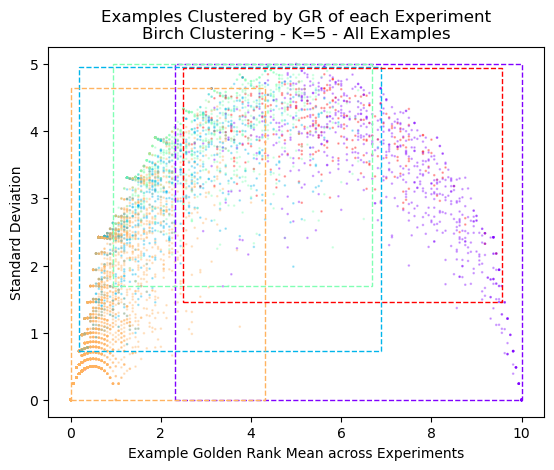

In [48]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 5

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster5_all") )
with open('../assets/cluster5_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))

print(counts_pd.to_string(index=False))


In [ ]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster4_all") )
with open('../assets/cluster4_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


In [ ]:
X = grs_na.T
X_means = grs_na_means
X_std = grs_na_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Non-Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_na") )
with open('../assets/cluster3_na.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


In [ ]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster4_ans") )
with open('../assets/cluster4_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


In [ ]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_ans") )
with open('../assets/cluster3_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))



## Golden Rank (GR)

The Golden Rank $R$ is the lowest rank in the order of descenting probability of the prediction exactly matching one of the golden answers. 

The output layer of the model yields a vector of start logits and end logits for each example.  These are then passed through masked softmax producing two probability vectors, one for the start marker and another for the end marker. 

The two probability vectors for each example are then combined to form a single probability which is the value provided in the top-N results. The choice of the function that combines the two probabilities to produce the combined probability in the Huggingface implementation is a simple average of the start and end probability. There are other possibilities however:

*   The product of the two probabilities can be used instead of the average (used in the BiDAF starter code) 
*   Taking a weighted average is discussed in various articles, for example in [*Question and Answering on SQuAD 2.0: BERT Is All You Need* by Schwager and Solitario](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf). They argue that the start probability carries more weight than the end probability so weighing the start twice as much as the end may be appropriate.
*  Hyperparameter settings favoring no-answer detection have weaker scores in F1 and exact match detection, and vice versa. This observation was made by the same paper above, and we confirmed it through our own experimentation. 

We now calculate the Golden Rank from the predictions in RS. 

The value maxBins is used to size the histograms to the ranks available in the data.
The topNPreds returns a list of dictionaries, one for each experiment. 
Each of these, are indexed by example ID, and they contain the list of ranked predictions for it. 
We walk down that list and rank the id with the rank of the first correct answer we encounter. If the list goes past the maxBins, the last bin contains the rank that captures the result. If no entry exists with a correct answer, then the default rank will be used.

In [ ]:
grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls = RS.calc_golden_ranks(maxBins = 10)
len(grls[10])

## Mean rank

Smaller is better

In [ ]:
np.mean(grls_np,axis=1)



## Median Rank

In [ ]:
[np.median([r  for r in L if r>0]) for L in grls]

## Interpolated Median Rank

In [ ]:
[median_grouped([r  for r in L if r>0]) for L in grls]


## Scaterplots of Interpolated Median and Mean

In [ ]:
grls = grls #RS.topNPreds(topK=10)
R = []
md = []
mn = []
df = []
score = []
for L in grls:
    M = len(L)
    R = [r for r in L if r > 0]
    #md.append(median_grouped(R))
    #mn.append(np.mean(R))
    #score.append(np.array(R).shape[0]/M*100)
    df.append([np.array(R).shape[0]/M*100,median_grouped(R),np.mean(R)])
#md = np.array(md)
#mn = np.array(mn)
#score = np.array(score)
df = pd.DataFrame(df)
df.columns = ['EM','Median','Mean']
df['labels'] = RS.labels


#plt.scatter(score,md)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs median\n of failed predictions")
#plt.show()

#plt.scatter(score,mn)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs mean\n of failed predictions")
#plt.show()

colors = cm.rainbow(np.linspace(0, 1, len(df)))

#plt.scatter(df.EM,df.Mean,color=colors)
#plt.title("Gold Pred Rank vs median and mean\n of failed predictions")
#plt.legend(labels=df.experiment,loc='upper right', bbox_to_anchor=(2, 1))
#plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)

plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.6, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)
plt.title("Gold Prediction EM and top-N size are correlated with Mean Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel("EM score")
plt.ylabel(" Rank")
plt.show()

df